<a href="https://colab.research.google.com/github/alex-kondr/Data_Science_HW_8/blob/main/HW_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train_, y_train_), (x_test_, y_test_) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 1s 0us/step


0
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253
  159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252
  252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239
  233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202
   84 252 253 122   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 

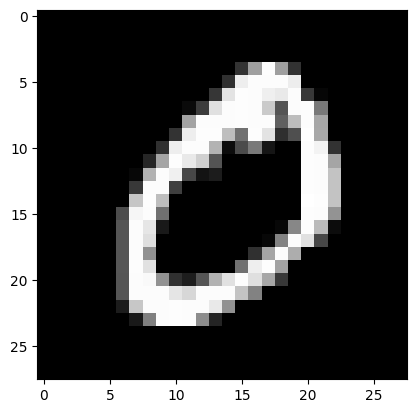

In [4]:
plt.imshow(x_train_[1], cmap="gray")
print(y_train_[1])
print(x_train_[1])

In [5]:
from keras.api._v2.keras import activations
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=False):
        y = tf.matmul(x, self.w) + self.b
        if activation:
          return tf.nn.softmax(y)
        else:
          return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(num_features, n_hidden_1)


    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)

    # Выходной слой
    self.layer_3 = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    # Место для вашего кода
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x, activation=True)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    #x = # Место для вашего кода
    return x

In [6]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    correct_prediction = tf.equal(
        tf.argmax(y_pred, 1),
        tf.cast(y_true, tf.int64)
    )
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [7]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    loss_ = tf.reduce_sum([tf.nn.l2_loss(var) for var in neural_net.trainable_variables])
    loss += learning_rate * loss_

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, nn.variables)
    optimizer.apply_gradients(zip(gradients, nn.variables))

    # Модифицируем параметры
    # Место для вашего кода

In [8]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        loss = cross_entropy(pred, batch_y)
        acrcy = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acrcy)
        print(f"Step: {step}, loss: {loss:.4f}, accuracy: {acrcy:.4f}")

Step: 100, loss: 334.7795, accuracy: 0.6328
Step: 200, loss: 196.2639, accuracy: 0.7773
Step: 300, loss: 194.3081, accuracy: 0.8125
Step: 400, loss: 163.6290, accuracy: 0.8086
Step: 500, loss: 145.6487, accuracy: 0.8164
Step: 600, loss: 132.5210, accuracy: 0.8555
Step: 700, loss: 121.7569, accuracy: 0.8438
Step: 800, loss: 100.9611, accuracy: 0.8945
Step: 900, loss: 109.8665, accuracy: 0.8828
Step: 1000, loss: 119.5562, accuracy: 0.8867
Step: 1100, loss: 116.1250, accuracy: 0.8594
Step: 1200, loss: 82.7063, accuracy: 0.8984
Step: 1300, loss: 92.5360, accuracy: 0.8984
Step: 1400, loss: 78.8804, accuracy: 0.9023
Step: 1500, loss: 77.3514, accuracy: 0.8984
Step: 1600, loss: 79.9746, accuracy: 0.8945
Step: 1700, loss: 58.7834, accuracy: 0.9258
Step: 1800, loss: 98.1206, accuracy: 0.9102
Step: 1900, loss: 57.1020, accuracy: 0.9180
Step: 2000, loss: 42.1862, accuracy: 0.9688
Step: 2100, loss: 76.5239, accuracy: 0.9141
Step: 2200, loss: 42.7609, accuracy: 0.9375
Step: 2300, loss: 109.3206, ac

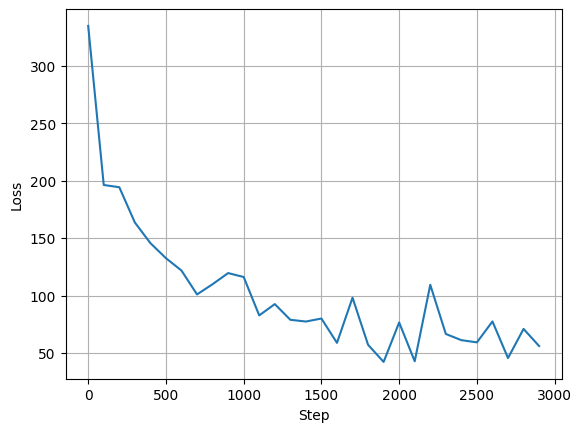

In [12]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

plt.plot(range(1, 3001, 100), loss_history)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()

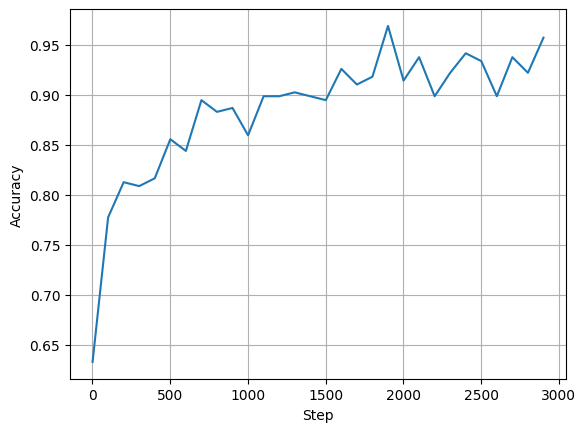

In [13]:
# Вычислите точность обученной нейросети

plt.plot(range(1, 3001, 100), accuracy_history)
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.grid()

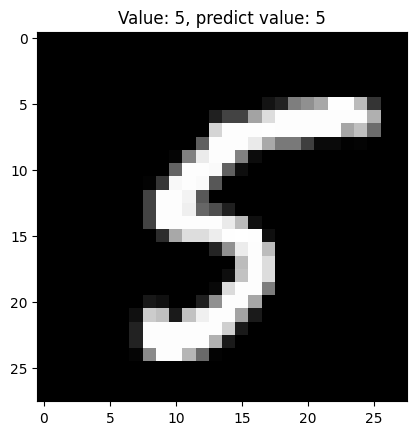

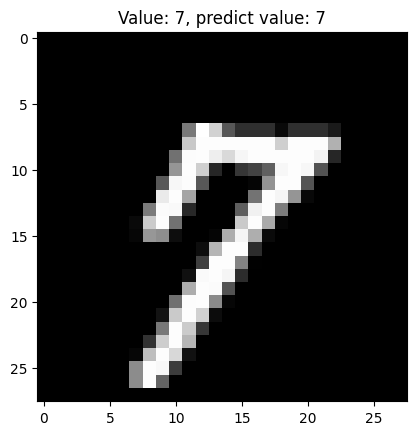

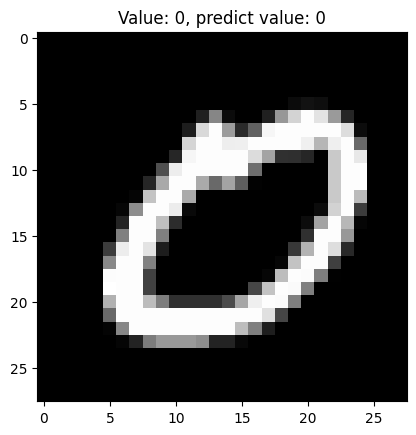

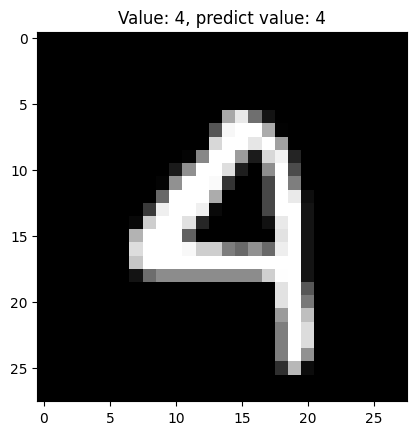

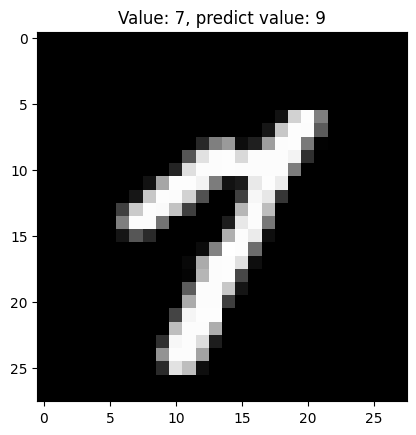

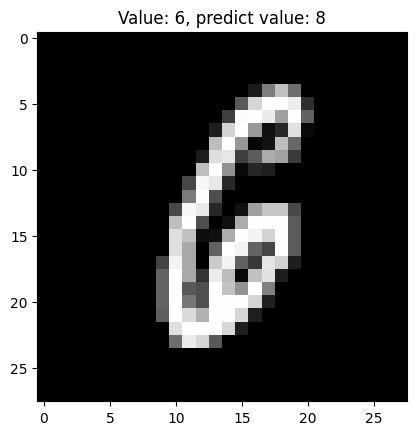

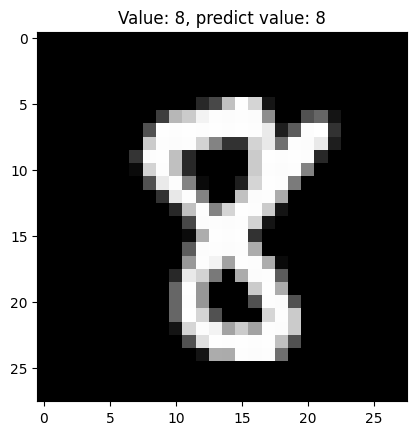

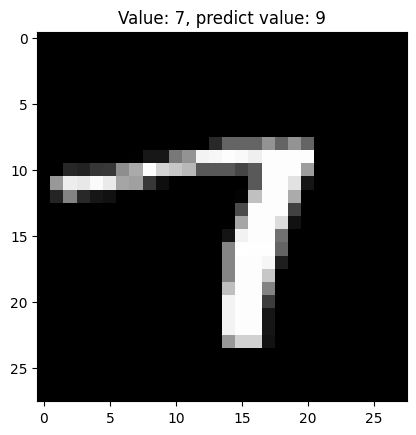

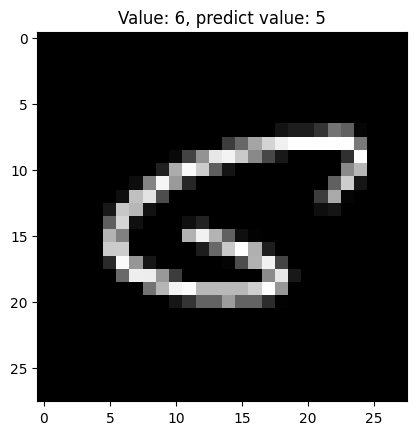

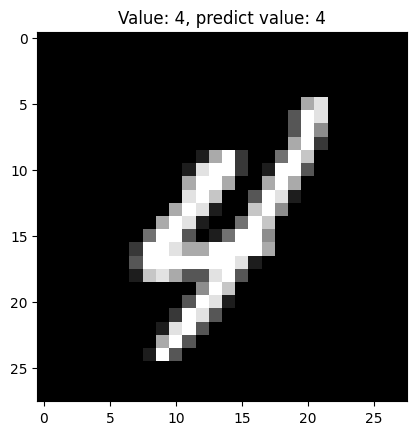

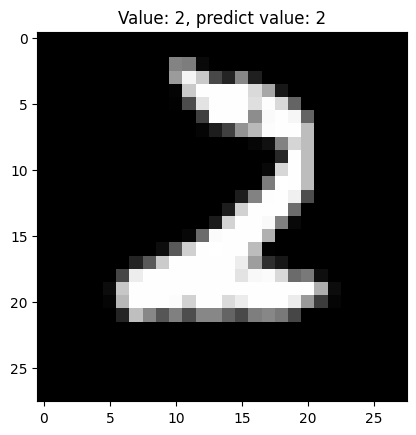

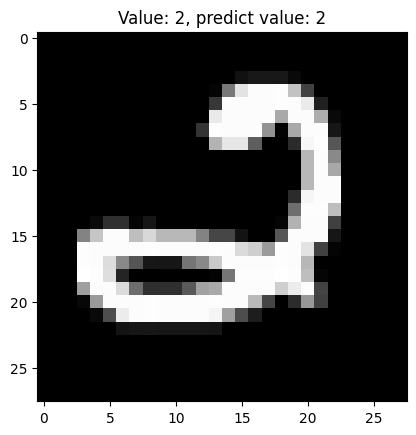

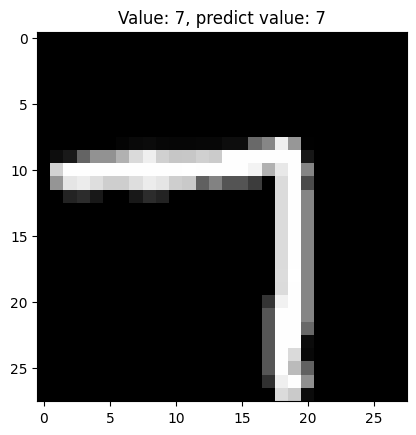

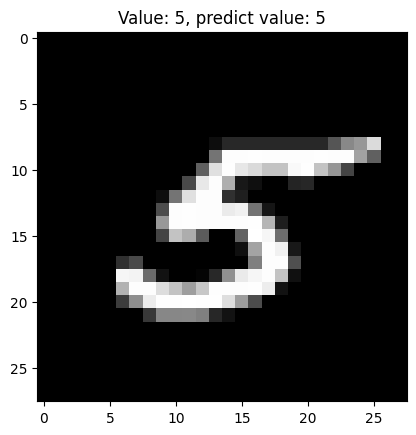

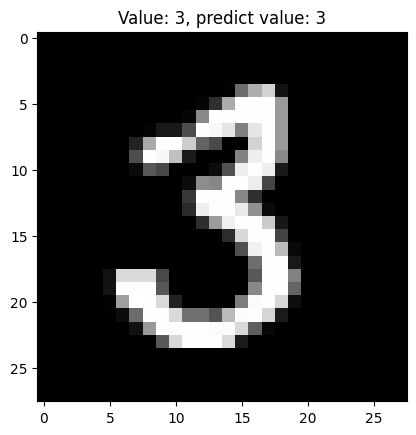

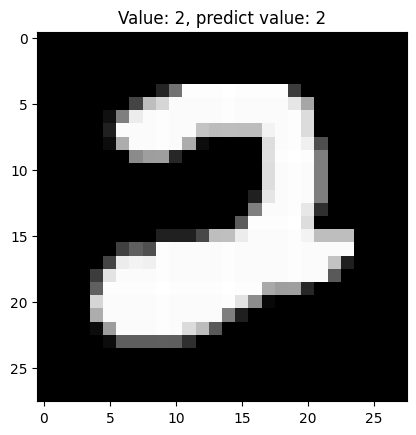

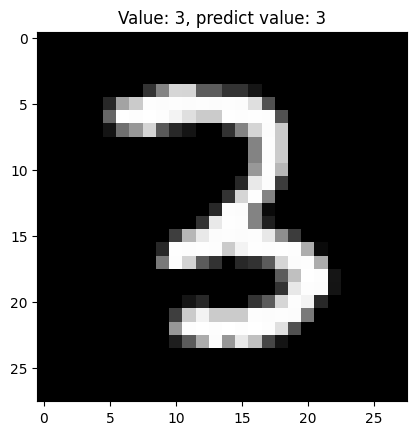

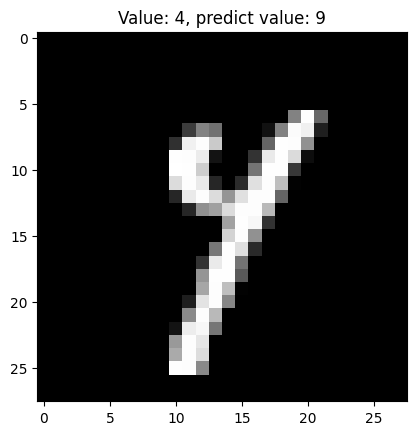

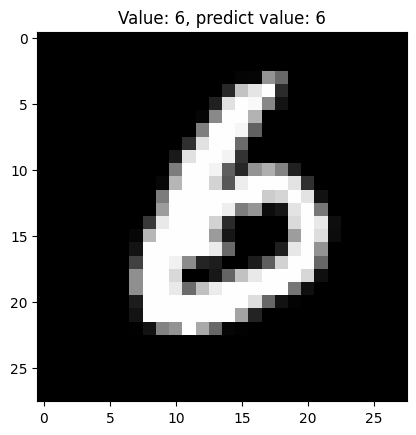

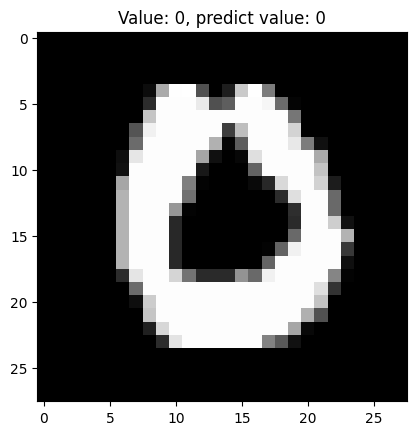

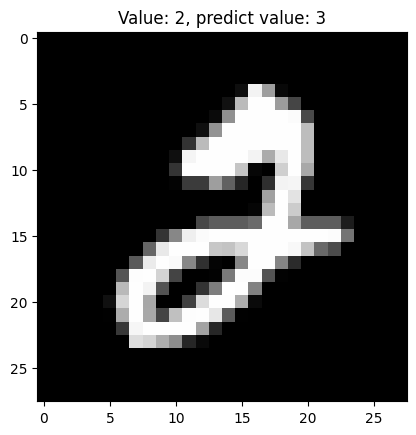

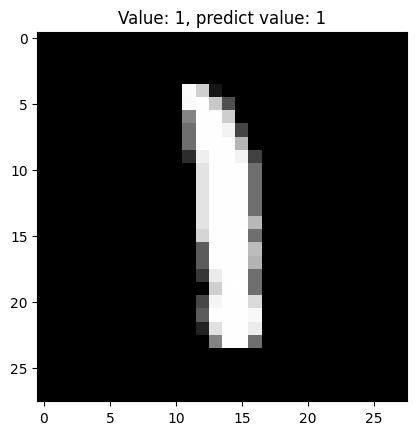

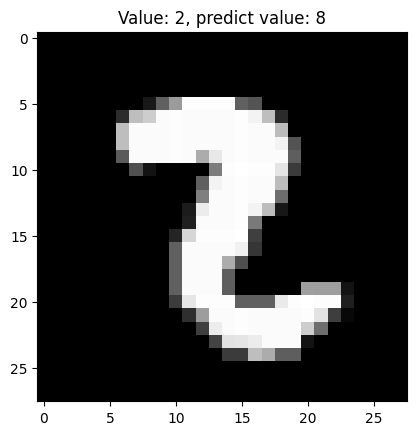

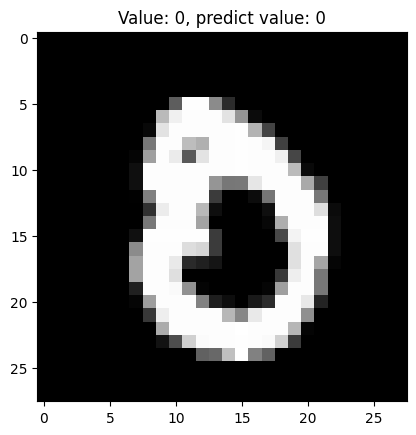

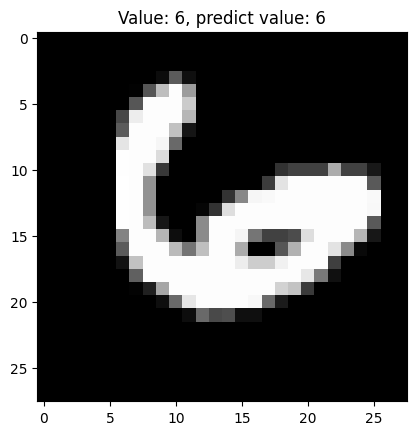

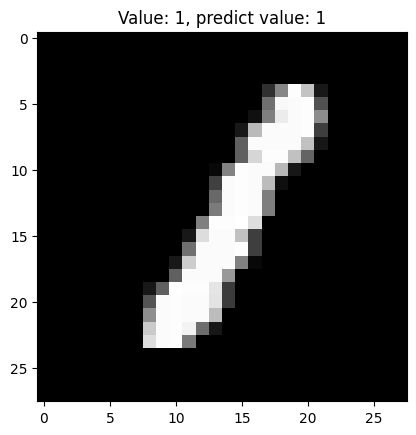

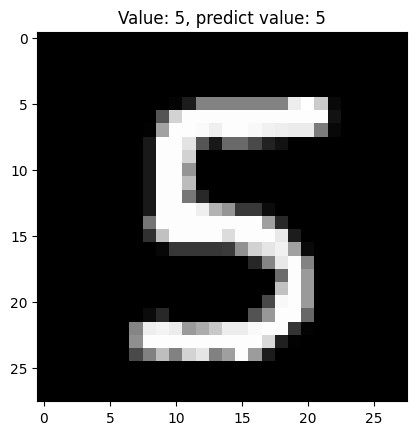

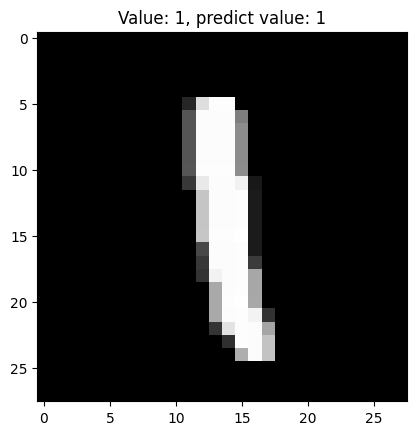

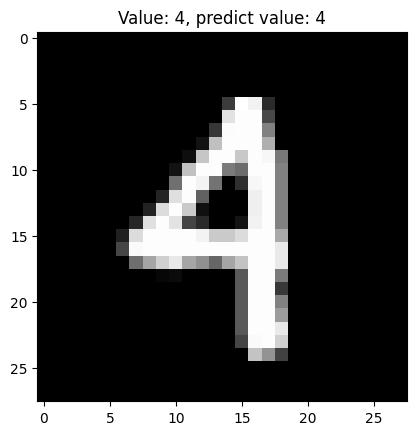

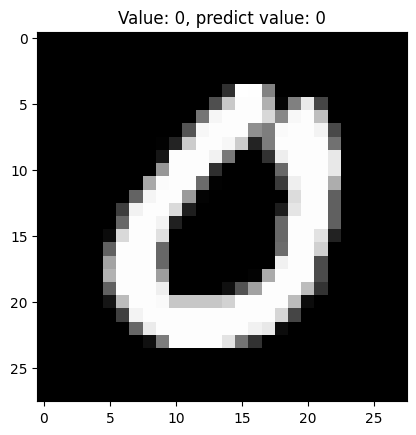

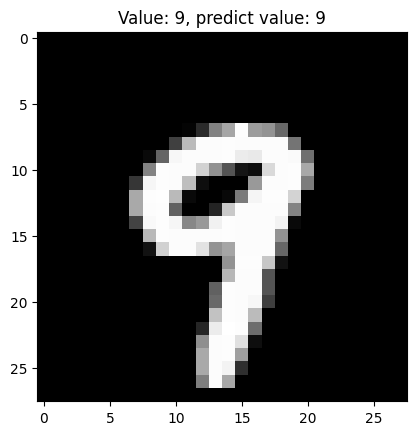

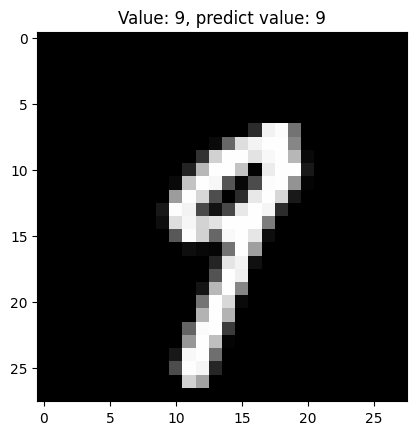

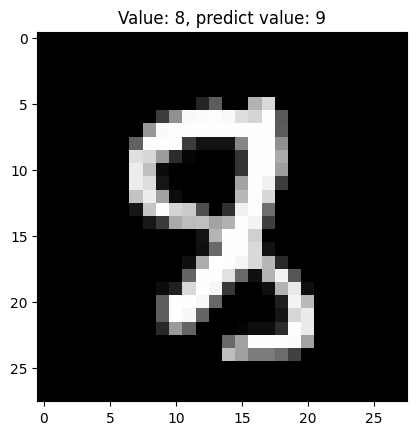

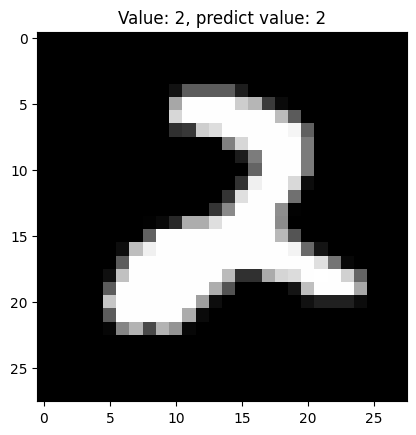

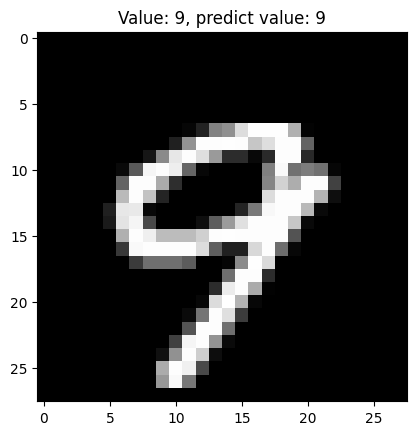

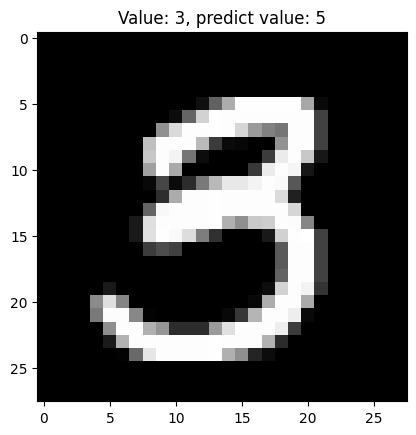

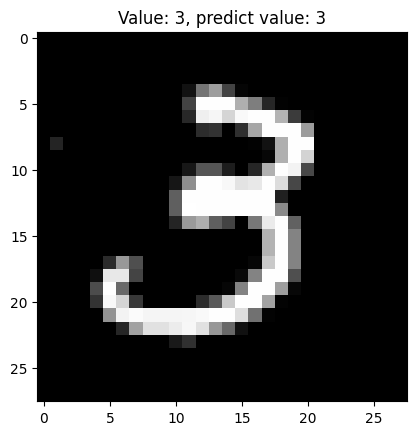

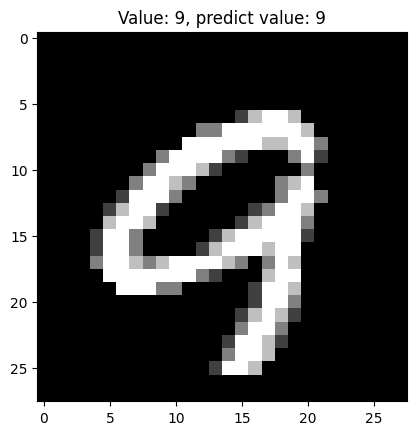

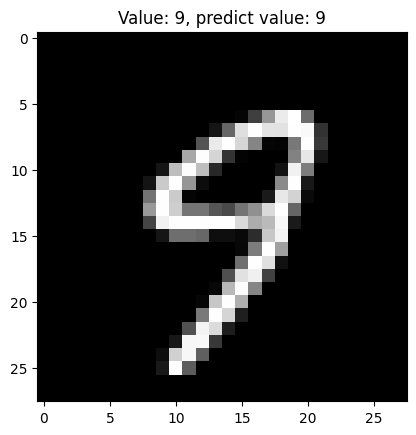

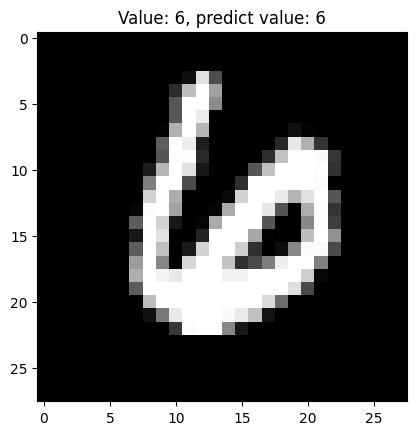

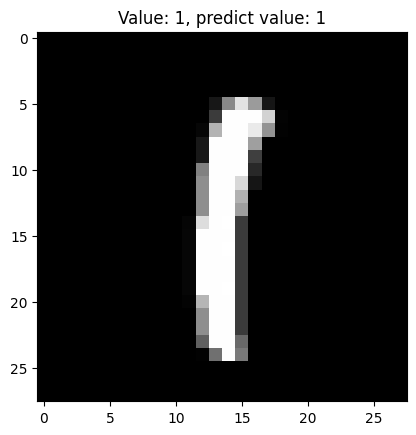

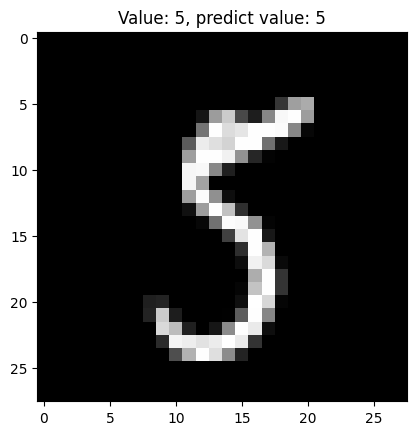

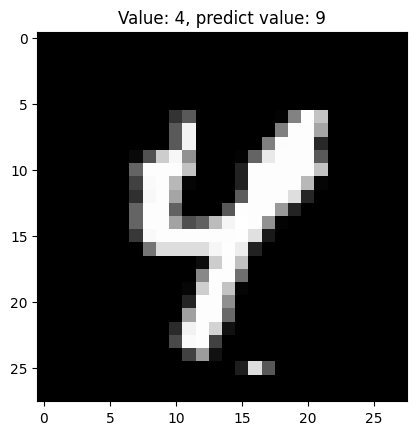

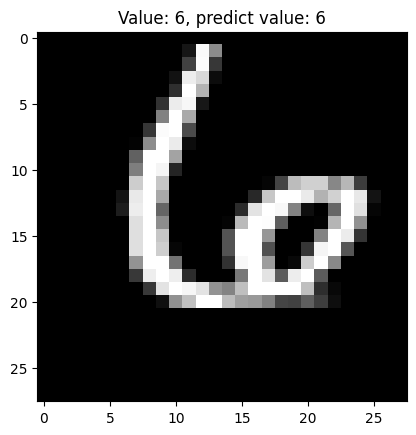

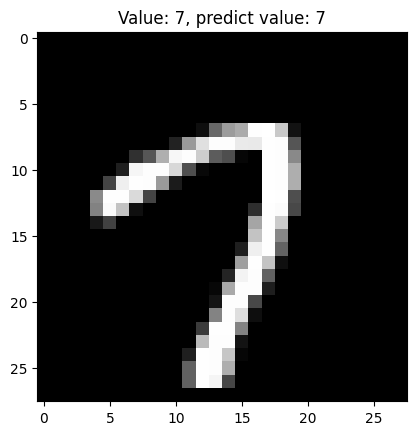

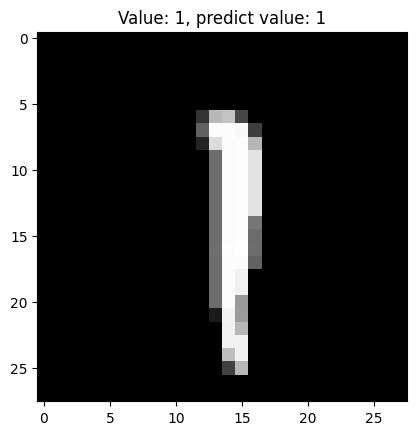

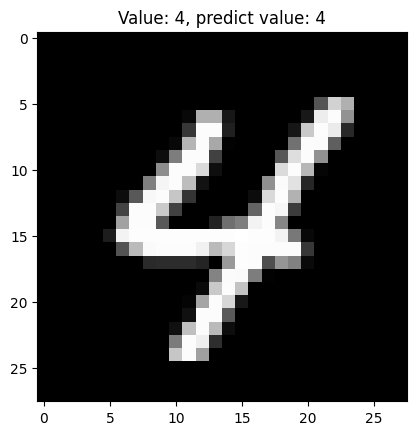

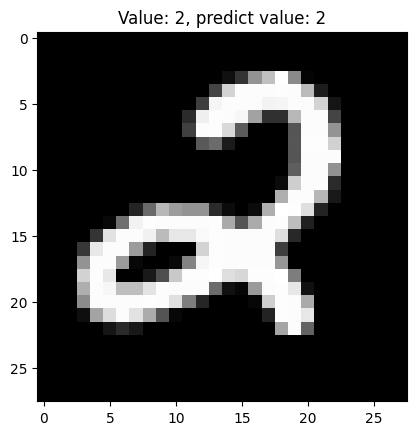

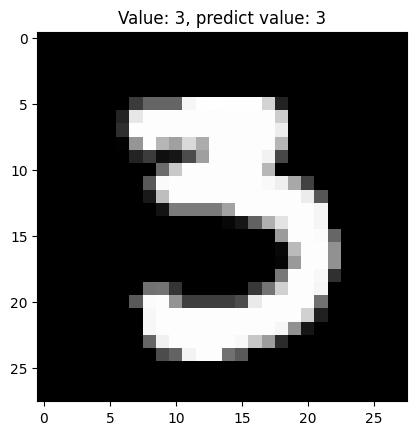

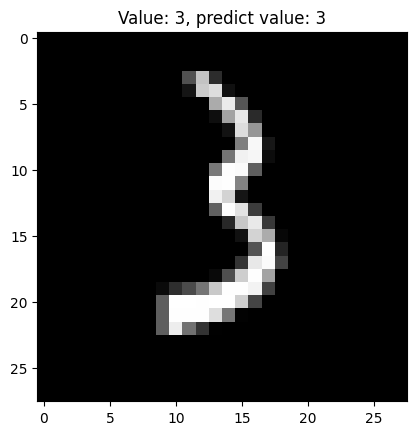

Accuracy of the trained neural network: 80.0%


In [18]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

images_number = 50
random_img = random.sample(range(len(x_test)), images_number)
test_img = x_test[random_img]
test_values = y_test[random_img]

predict = neural_net(test_img)
predict_values = tf.argmax(predict, axis=1)

accuracy = 0

for i in range(len(test_img)):
    image = test_img[i].reshape((28, 28))
    value = test_values[i]
    predict_value = predict_values[i]
    if predict_value == value:
      accuracy += 100/images_number
    plt.imshow(image, cmap='gray')
    # plt.axis('off')
    plt.title(f"Value: {value}, predict value: {predict_value}")
    plt.show()

print(f'Accuracy of the trained neural network: {accuracy}%')

Висновок: нейронна мережа досить не погано справляється з чітко написаними цифрами. Але погано розпізнає з недописаними цтфрами, або цифри написани під кутом. Для підвищення точності розпізнавання можна спробувати повертати та/або центрувати цифри.